In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from numpy.random import normal

from numpy.linalg import norm
from scipy.stats import norm

import yfinance as yf
from fredapi import Fred

In [99]:
# helper functions for this chapter

def HHI(sign_returns):
    
    w = sign_returns / sign_returns.sum()
    w_norm = w.shape[0]
    h = (np.pow(w, 2).sum() - 1/w_norm) / (1 - 1/w_norm)

    return h

def compute_DD_TuW(pnl_frame, percentile):
    pnl_frame["HWM"] = pnl_frame["Dollar PnL"].expanding().max()

    pnl_frame["HWM Regime"] = (pnl_frame["HWM"] != pnl_frame["HWM"].shift(1)).cumsum()-1
    
    draw_down_calc = (pnl_frame.groupby('HWM Regime')
                               .agg(first=('Close', "first"),
                                    min=('Close', "min"))
                     )
    draw_down_calc["loss"] = draw_down_calc["min"]/draw_down_calc["first"] - 1    
    DD = draw_down_calc["loss"].quantile(1-percentile)
    
    under_water_calc = (pnl_frame.reset_index(names="Date")
                                 .groupby('HWM Regime')
                                 .agg(first=('Date', "first"),
                                      last=('Date', "last"))
                       )
    under_water_calc["Duration"] = (under_water_calc["last"] - under_water_calc["first"]).dt.days
    TuW = under_water_calc["Duration"].quantile(percentile)
    
    return DD, TuW
    
    
def compute_annualized_avg_return(frame):
    # Accrue daily returns and annualize

    overall_return = (1 + frame["Return"]).prod()
    years = frame.shape[0] / 252
    annualized_return = np.pow(overall_return, 1/years) - 1

    return annualized_return


def avg_returns_from_hits(frame):
    # assumes daily bet
    
    hits = frame[frame["Return"] > 0]
    mean_hit = hits["Return"].mean()
    
    return (1 + mean_hit)**(1/252)-1    

def avg_returns_from_misses(frame):
    # assumes daily bet
    
    misses = frame[frame["Return"] < 0]
    mean_miss = misses["Return"].mean()
    
    return (1 + mean_miss)**(1/252)-1
    
def compute_annualized_sharpe(frame):
    # assumes daily bet
    
    mean_return = frame["Return"].mean()
    std_return = frame["Return"].std()
    sharpe = mean_return / std_return

    return np.sqrt(252)*sharpe

def compute_annualized_information_ratio(frame):
    # uses fed funds as benchmark
    frame = frame.copy()
        
    frame["Daily Benchmark"] = frame["Risk Free Rate"] / 360 # ACT/360 Day Count convention

    mean_return_over_benchmark = (frame["Return"] - frame["Daily Benchmark"]).mean()
    std_return_over_benchmark = (frame["Return"] - frame["Daily Benchmark"]).std()

    information_ratio = mean_return_over_benchmark / std_return_over_benchmark

    return np.sqrt(252)*information_ratio
 

def compute_PSR(benchmark, SR_observed, observations, skew, kurtosis):
    num = (SR_observed - benchmark) * np.sqrt(observations - 1)
    denom = np.sqrt(1 - skew * SR_observed + (kurtosis - 1)*SR_observed**2/4)

    return norm.cdf(num/denom)

def _benchmark_for_DSR(var_trials, trials):
    gamma = 0.57721566
    
    benchmark = np.sqrt(var_trials)*((1 - gamma)*norm.ppf(1 - 1/trials) + gamma*norm.ppf(1 - np.exp(-1)/trials))
    
    return benchmark

def compute_DSR(SR_observed, observations, trials, var_trials, skew, kurtosis):

    # Returns benchmark in whatever unit the SR is provided in
    benchmark = _benchmark_for_DSR(var_trials, trials) 
    
    return benchmark, compute_PSR(benchmark, SR_observed, observations, skew, kurtosis)

# Exercises 

### 14.1

A strategy exhibits a high turnover, high leverage, and high number of bets, with
a short holding period, low return on execution costs, and a high Sharpe ratio.
Is it likely to have large capacity? What kind of strategy do you think it is?

This is an HFT strategy using leverage to amplify returns. It likely has a low capacity, as additional transaction costs will each away at PnL

### 14.2

On the dollar bars dataset for E-mini S&P 500 futures, compute

(a) HHI index on positive returns.

(b) HHI index on negative returns.

(c) HHI index on time between bars.

(d) The 95-percentile DD.

(e) The 95-percentile TuW.

(f) Annualized average return.

(g) Average returns from hits (positive returns).

(h) Average return from misses (negative returns).

(i) Annualized SR.

(j) Information ratio, where the benchmark is the risk-free rate.

(k) PSR.

(l) DSR, where we assume there were 100 trials, and the variance of the trials’
SR was 0.5.

Text(0, 0.5, 'Index Level')

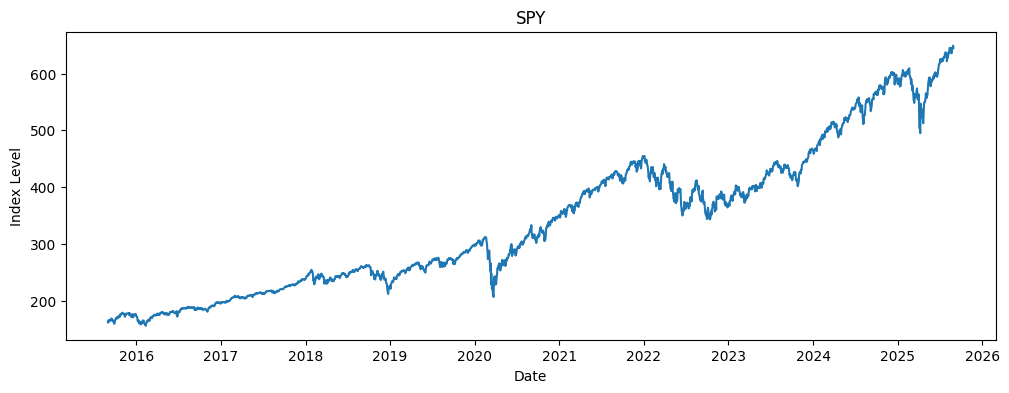

In [100]:
# we'll take data from Yahoo Finance and FRED for simplicity
ticker = yf.Ticker("SPY")

spy = ticker.history(period="10y", interval="1d")  
spy.index = spy.index.date
spy.index = pd.to_datetime(spy.index)
spy = spy.drop(["Dividends", "Stock Splits", "Capital Gains"], axis=1)



from fredapi import Fred
fred = Fred(api_key='635cbac60d1b852b7c3492573b2b4f64')
fed_funds = fred.get_series('FEDFUNDS') / 100

spy["Risk Free Rate"] = fed_funds.to_frame()[0]
spy["Risk Free Rate"] = spy["Risk Free Rate"].ffill()

spy["Return"] = spy["Close"]/spy["Close"].shift(1) - 1
spy = spy.dropna()

spy["Dollar PnL"] = spy["Close"] / spy["Close"].values[0] - 1


plt.figure(figsize=(12, 4))
plt.plot(spy["Close"])

plt.title("SPY")
plt.xlabel("Date")
plt.ylabel("Index Level")

In [104]:
# Calculate and summary attributes

ret = spy["Return"].values

positive_HHI = HHI(ret[ret>=0])
negative_HHI = HHI(ret[ret<0])

max_drawdown, max_TuW = compute_DD_TuW(spy, percentile=0.95)

annualized_return = compute_annualized_avg_return(spy)

returns_from_hits = avg_returns_from_hits(spy)
returns_from_misses = avg_returns_from_misses(spy)

annualized_sharpe = compute_annualized_sharpe(spy)

information_ratio = compute_information_ratio(spy)

# SR_observation, skew, and kurtosis should all be on a daily basis
PSR=compute_PSR(benchmark=0, 
                SR_observed=information_ratio/np.sqrt(252), 
                observations=spy.shape[0], 
                skew=spy["Return"].skew(), 
                kurtosis=spy["Return"].kurtosis()+3)

# returns DSR_benchmark as daily sharpe ratio
DSR_Benchmark, DSR = compute_DSR(SR_observed=information_ratio/np.sqrt(252), 
                                 observations=spy.shape[0],
                                 trials=2, 
                                 var_trials=0.5,
                                 skew=spy["Return"].skew(), 
                                 kurtosis=spy["Return"].kurtosis()+3)


labels = ["HHI positive returns", 
          "HHI negative returns",
          "95%-ile DD",
          "95%-ile TuW",
          "Ann. avg return",
          "Ann. Avg. return from hits",
          "Ann. Avg. return from misses",
          "Annualized SR (no benchmark)",
          "Information Ratio (Fed Funds benchmark)",
          "PSR",
          "DSR",
          "DSR Benchmark"]

data = [positive_HHI, 
        negative_HHI, 
        max_drawdown, 
        max_TuW, 
        annualized_return, 
        returns_from_hits,
        returns_from_misses,
        annualized_sharpe,
        information_ratio,
        PSR,
        DSR,
        DSR_Benchmark*np.sqrt(252)]

data = [round(x, 4) for x in data]

pd.DataFrame(index=labels, data=data, columns=["Attribute Value"])

,Attribute Value
HHI positive returns,0.0009
HHI negative returns,0.0014
95%-ile DD,-0.0374
95%-ile TuW,26.0500
Ann. avg return,0.1453
Ann. Avg. return from hits,0.0000
Ann. Avg. return from misses,-0.0000
Annualized SR (no benchmark),0.8386
Information Ratio (Fed Funds benchmark),0.7593
PSR,0.9911


### 14.4 

The results from a 2-year backtest are that monthly returns have a mean of 3.6%,
and a standard deviation of 7.9%.

(a) What is the SR?

(b) What is the annualized SR?

The monthly Sharpe Ratio is $SR = \frac{3.6}{7.9} = 0.46$. The annualized Sharpe Ratio is $SR = \sqrt{12}*\frac{3.6}{7.9} = 1.58$

### 14.5

Following on exercise 1:

(a) The returns have a skewness of 0 and a kurtosis of 3. What is the PSR?

(b) The returns have a skewness of -2.448 and a kurtosis of 10.164. What is the
PSR?

In [105]:
# No sampling frequency given, so just use yearly numbers
Gaussian_PSR = compute_PSR(benchmark = 1, 
                           SR_observed = 1.5, 
                           observations = 5, 
                           skew = 0, 
                           kurtosis = 3)

print(F"PSR: {Gaussian_PSR}")

PSR: 0.753641661386456


In [106]:
# No sampling frequency given, so just use yearly numbers
tailed_PSR = compute_PSR(benchmark = 1, 
                         SR_observed = 1.5, 
                         observations = 5, 
                         skew = -2.448, 
                         kurtosis = 10.164)

print(F"PSR: {tailed_PSR}")

PSR: 0.6251379587597063


All else equal, the skew and the fat tails decrease the probability that the observed Sharpe Ratio is greater than the benchmark. This makes sense, as skew and fat tailed distributions tend to inflate the Sharp Ratio.

### 14.7

14.7 A 5-year backtest has an annualized SR of 2.5, computed on daily returns. The
skewness is -3 and the kurtosis is 10.

(a) What is the PSR?

(b) In order to find that best result, 100 trials were conducted. The variance of
the Sharpe ratios on those trials is 0.5. What is the DSR?

In [107]:
# The Probabilistic Sharpe Ratio is virtually equal to 1

# All numbers so be in the original sampling frequency, i.e. not annualized
PSR = compute_PSR(benchmark = 0, 
                  SR_observed = 2.5 / np.sqrt(252),
                  observations = 5*252, 
                  skew = -3, 
                  kurtosis = 10)

print(F"PSR: {PSR}")

PSR: 0.9999969103986683


In [108]:
DSR_Benchmark, DSR = compute_DSR(SR_observed=2.5/np.sqrt(252), 
                                 observations=5*252,
                                 trials=100, 
                                 var_trials=0.5/252,
                                 skew=-3, 
                                 kurtosis=10)
print(F"DSR: {DSR}")

DSR: 0.9005688129049774


The Probability of the Sharpe Ratio being non zero is high. However, the probability of the observed Sharpe Ratio being higher than the DSR benchmark is substantially lower.